In [3]:
import msgpack
import open3d as o3d
# import trimesh
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import time
import threading


import ipywidgets.widgets as widgets
import ipywidgets
from IPython.display import display

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# %autoawait off

import socket
# import asyncio
# # # !pip install nest-asyncio
# import nest_asyncio
# # nest_asyncio.apply() 

In [4]:
PI = np.pi
TWO_PI = 2*np.pi

# UDP header constant
UDP_RESET=15
UDP_ROBOT_STATE_REPORT=14
UDP_MOTOR_SPEED_COMMEND=13
UDP_MOTOR_POS_COMMEND=12


ip_local = "127.0.0.1"
port_local = 32000

ip_remote = "127.0.0.1"
port_remote = 32001

BUFFER_LEN = 512 #in bytes

local_address = (ip_local,port_local)
remote_address = (ip_remote,port_remote)

packer = msgpack.Packer(use_single_float=True,use_bin_type =True)

### Create a UDP socket

In [5]:
# https://adaickalavan.github.io/programming/udp-socket-programming-in-cpp-and-python/
# Python UDP Receiver
#Create a datagram socket
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#Enable/disable immediate reuse of IP address
sock.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,0)
#Set a timeout so the socket does not block indefinitely when trying to receive data
sock.settimeout(1)
#Bind the socket to the port
sock.bind(local_address)
# sock.connect(remote_address)

# for closing connection:
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

### test receiving udp packet

In [6]:
s = time.perf_counter()
try:
    data = sock.recv(BUFFER_LEN)
    data_unpacked = msgpack.unpackb(data)
    print(data_unpacked)
except Exception as e:
    print(e)
    pass
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

elapsed = time.perf_counter() - s

print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")


[14, 213.52000000029142, [2.2956919943405256, 2.2570121011495745, 2.2967350081602413, 2.291678691873995], [2.1649516519652856, 2.652739217103184, 2.2366814174223926, 2.0235890252584543], [-2.5644704325833945, 1.4249777972388147, -0.7327368980884703], [-0.7344109651456736, 0.5417506591181533, 0.4088358565718602, 0.337828858422704, -0.23065975622667612, 0.9125062954710302], [0.06550304440574667, -0.014569086711027537, 0.0630594998463154]]
#--- executed in 0.45 ms ---#


### test sending udp packet

In [5]:
# sen_sock = initUDP(ip_remote, port_local) # socket that send udp packet

# data_send = [UDP_RESET,time.time(),[0,0,0,0]]
data_send = [UDP_MOTOR_SPEED_COMMEND,time.time(),[2,2,-2,-2]]

# data_send = [0.5,0.0,1.0,2.0]
# data_send = [1,2,3,4]

# data_send = 20

data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# data_send_packed = msgpack.packb(data_send)

num_bytes_send = sock.sendto(data_send_packed,remote_address)

print(data_send)
print(data_send_packed)

[13, 1600973693.2841005, [2, 2, -2, -2]]
b'\x93\r\xcaN\xbe\xd9\xd7\x94\x02\x02\xfe\xfe'


In [100]:
w_max = round(650.0/60.0*np.pi*2)

pos_max = np.pi

# flag_start = True
# flag_should_send = False
# flag_reset = False

# stop button
button_stop = widgets.Button(
    description='stop',
    icon='stop',
    button_style='warning')

def OnClickButtonStop(b):
    global flag_start
    flag_start=False
button_stop.on_click(OnClickButtonStop)  

# reset button
button_reset = widgets.Button(
    description='reset',
    icon='refresh',
    button_style='info')
def OnClickButtonReset(b):
    global flag_reset
    flag_reset = True
button_reset.on_click(OnClickButtonReset) 


# restart button
button_restart = widgets.Button(
    description='restart',
    icon='refresh',
    button_style='warning')

def OnClickButtonRestart(b):
    OnClickButtonReset(b)
    flag_start=True
    data_send = (UDP_RESET,time.time(),(0, 0, 0, 0))
    data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
    sock.sendto(data_send_packed,remote_address)
#     print("restarted")
button_restart.on_click(OnClickButtonRestart) 



joint_vel_widgets = [
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#front left 
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#back left  
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#front right
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True)#back right 
]

joint_pos_widgets = [
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#front left 
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#back left  
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True),#front right
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True)#back right 
]

speed_widget = widgets.FloatSlider(min=-int(w_max/2.5), max=int(w_max/2.5), step=1, value=0.0,
                                   continuous_update=False, description="Speed")

s_base_widget = widgets.FloatSlider(min=0.1, max=0.9, step=.02, value=0.6,
                                   continuous_update=False, description="s base")

s_offset_widget = widgets.FloatSlider(min=-0.16, max=0.16, step=.02, value=0.0,
                                   continuous_update=False, description="s offset")


joint_labels = [
    widgets.Label(value='front left'),
    widgets.Label(value='back left'),
    widgets.Label(value='front right'),
    widgets.Label(value='back right'),
]


caption_list = [
    widgets.Label(value='[Joint Angle]'),
    widgets.Label(value='[Joint speed]'),
    widgets.Label(value='[Accelerration]'),
    widgets.Label(value='[Orientation]'),
    widgets.Label(value='[Position]'),
]

    
ui_vel_pos_widget = widgets.HBox([
    widgets.VBox([widgets.Label("")]+joint_labels),
    widgets.VBox([widgets.Label(" joint vel [rad/s]")]+joint_vel_widgets),
    widgets.VBox([widgets.Label("joint pos [rad]")]+joint_pos_widgets)])

ui = widgets.VBox([ui_vel_pos_widget]+[speed_widget,s_base_widget,s_offset_widget]+caption_list)

# def f(w0, w1, w2, w3):
#     global flag_should_send
#     flag_should_send = True
# #     time_now = time.time()
# #     data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,(w0, w1, w2, w3))
# # #     display(data_send)
# # #     data_send_packed = msgpack.packb(data_send)
# #     data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# # #     display(data_send_packed)
# #     sock.sendto(data_send_packed,remote_address)
# # #     display((f"{time.time():3.3f}", (w0, w1, w2, w3)))
    
# out = widgets.interactive_output(f, {
#     'w0': joint_vel_widgets[0],
#     'w1': joint_vel_widgets[1],
#     'w2': joint_vel_widgets[2],
#     'w3': joint_vel_widgets[3]
# })
# out.layout.height = '350px'
# out.layout.width = '350px'


buttons_ui = widgets.HBox((button_stop,button_reset,button_restart))

# app = widgets.VBox(
#     children = (ui, out,buttons_ui))
app = widgets.VBox(
    children = (ui,buttons_ui))
# display(app)

17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003


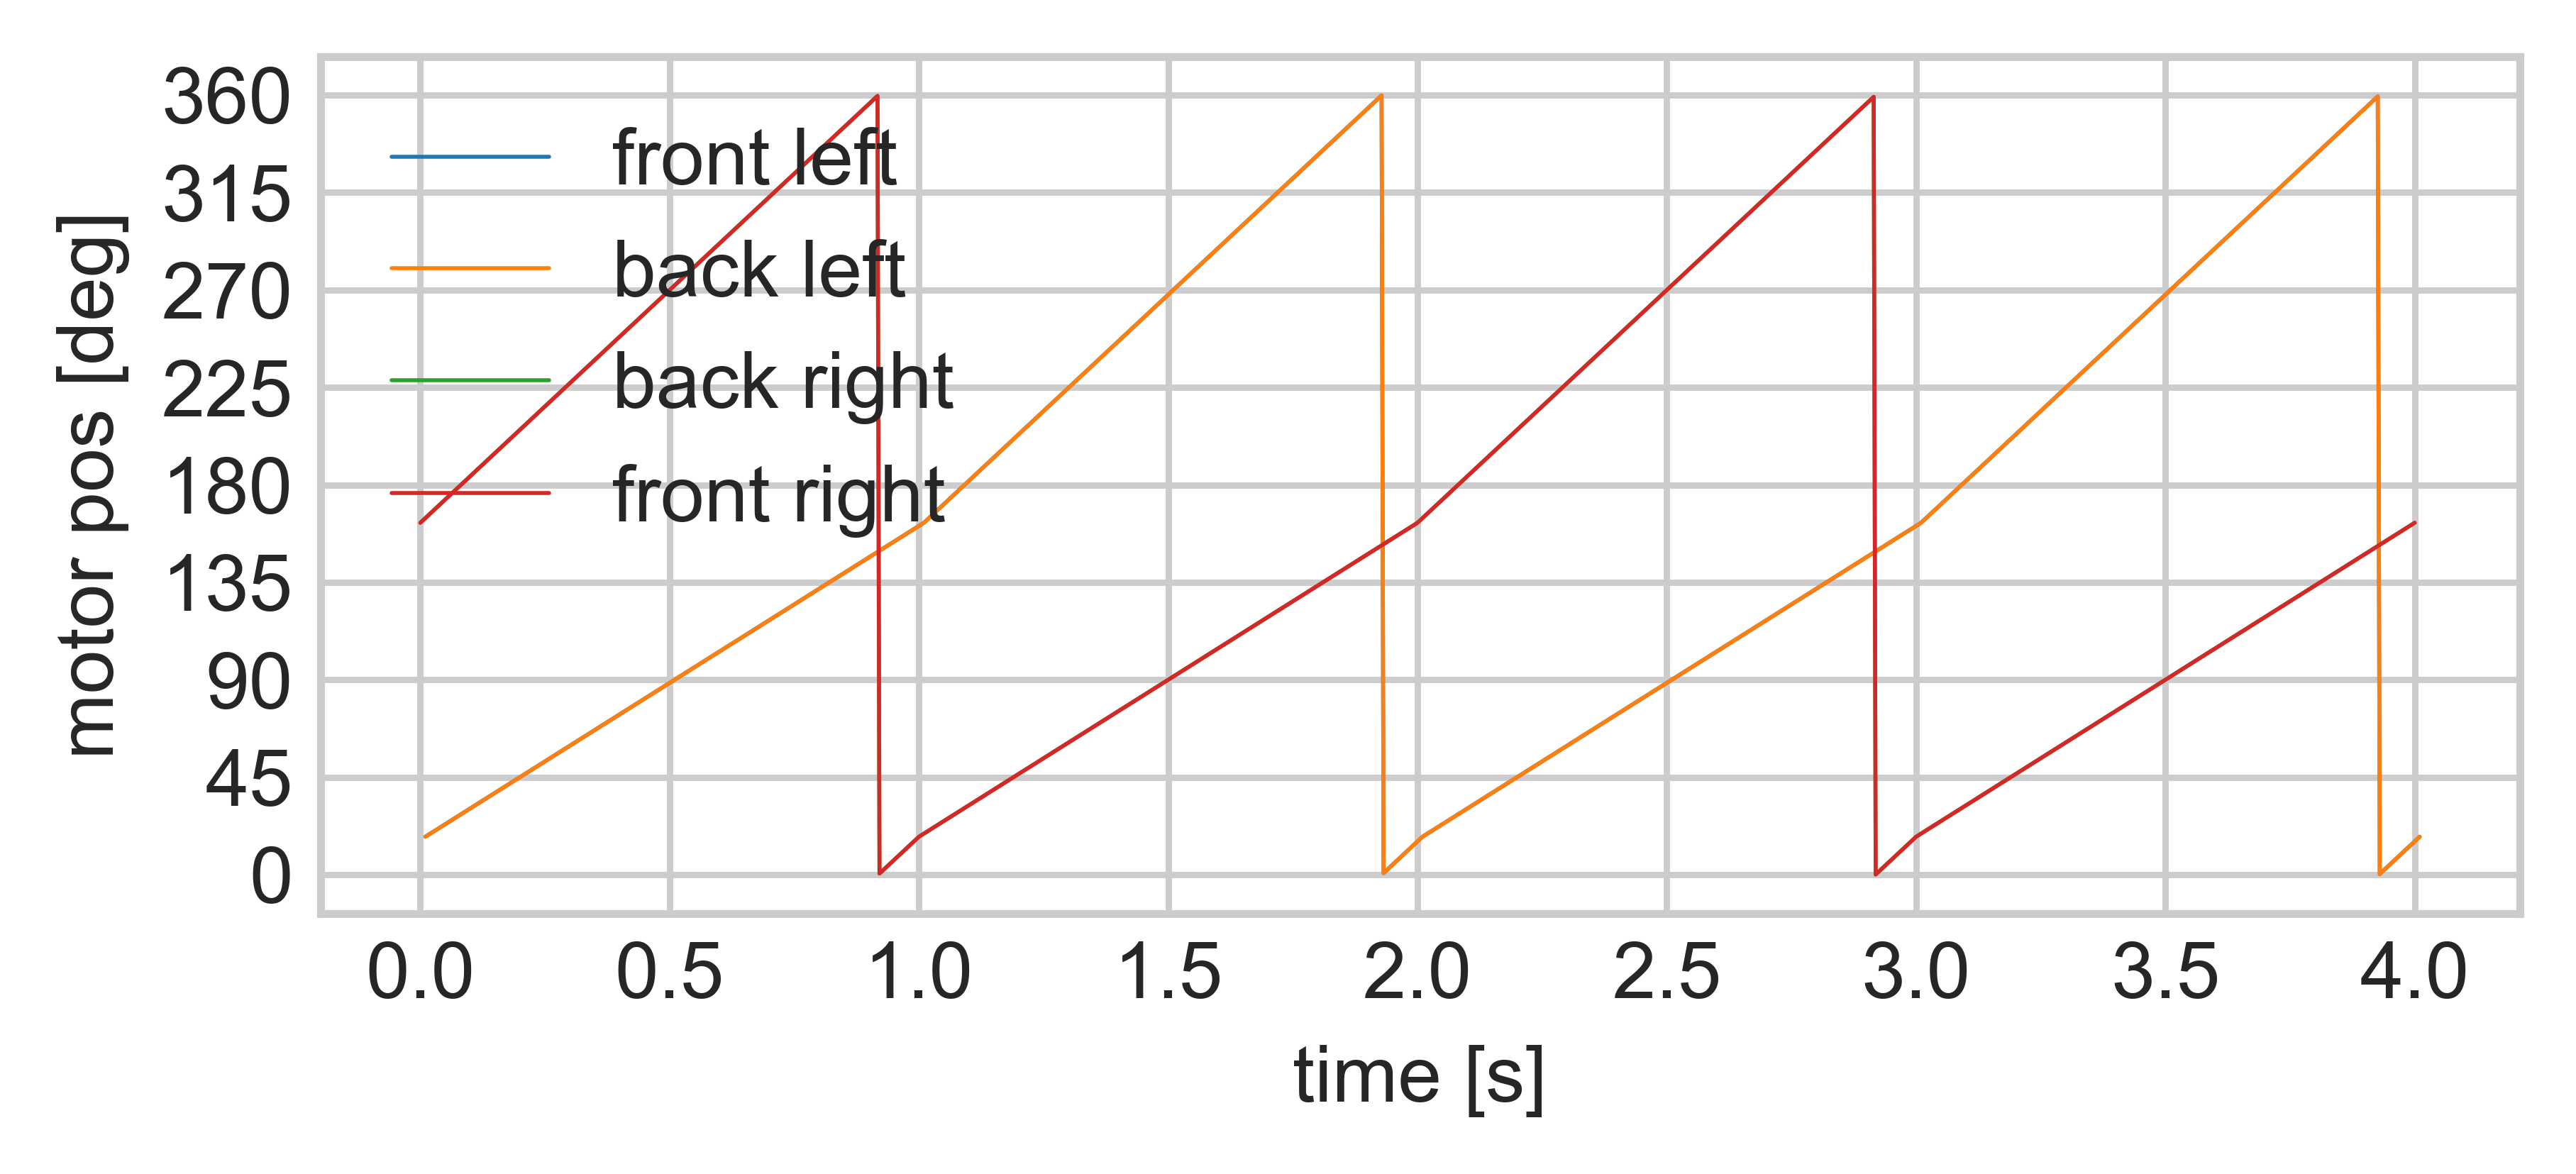

In [126]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'


PI = np.pi
TWO_PI = 2*np.pi

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 0.1*np.pi, # average angular velocity [rad/s]
                 s = 0.5, # stance ratio = stance_time/cycle_time [unitless]
                 contact_angle = 120/180*PI, # contact_angle [rad]
                 p_stance_mid = 1.*np.pi,# angle at the middle of the stance phase [rad]
                 t =0, # time at current step
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = w # average angular velocity [rad/s]
        this.c = contact_angle # contact_angle [rad]
#         this.contact_angle
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        
        this.t = t # time at current step
        this.tc = this.ot # converted time [0-1,unitless]
        
        this.T = 2*np.pi/this.w # cycle time
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = this.c/(this.s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        this.wa = (TWO_PI-this.c)/(1-this.s) # w_air, (time normalized) average angular velocity of air phase [rad]
        
        this.p_stance_high = p_stance_mid + this.c/2.0
        print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)
        
#     @njit
#     def UpdateStanceRatio(this,s):
#         """
#         update the stance ratio s (=: stance_time/cycle_time [unitless])
#         """
#         ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
#         wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
#         # update the converted (normalized) time this.tc
        
#         pos_raw = (this.pos -this.p_stance_low)%TWO_PI
#         if pos_raw<0:
#             pos_raw+=TWO_PI # convert to 0-2PI
#         if pos_raw<this.c:
#             this.tc = pos_raw/ws
#         else:
#             this.tc = (pos_raw-this.c)/wa+s
            
#         this.s = s # stance ratio = stance_time/cycle_time [unitless]
#         this.ws = ws
#         this.wa = wa

    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
        # update the converted (normalized) time this.tc
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = ws
        this.wa = wa
        
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
            


    def GetPos(this, t,w=None,s=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w is not None:
            this.w = w
        if (s is not None) and s!=this.s:
            this.UpdateStanceRatio(s)
        dt = t - this.t # differenct in raw time
        this.t = t
        dnt = this.w*dt/TWO_PI # normalized phase difference [0-1][unitless]
        this.tc = (this.tc + dnt)%1.0 # # current converted time [0-1,unitless]
        
        # todo sign
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
        return this.pos

    def _UpdateAngularVelocity(this,t,w):        
        this.w = w # TODO direction
    


gaits = [ # trotting gait #2 alternate gait
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI)] # front right


# gaits = [ # bounding gait
#     WalkingTrot(0,p_stance_mid = 1./3.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0.5,p_stance_mid = 1./3.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0.5,p_stance_mid = 1./3.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./3.*np.pi,contact_angle = 180/180*PI) # front right
# ]

# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]
# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]

# gaits = [ # crawl gait
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 150/180*PI,s = 0.8),# front left
#     WalkingTrot(0.25,p_stance_mid = 1./2.*np.pi,contact_angle = 150/180*PI,s = 0.8), # back left
#     WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 150/180*PI,s = 0.8), # back right
#     WalkingTrot(0.75,p_stance_mid = 1./2.*np.pi,contact_angle = 150/180*PI,s = 0.8) # front right
# ]

# gaits = [ # crawl gait #2
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI),# front left
#     WalkingTrot(0.75,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI), # back left
#     WalkingTrot(0.25,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI), # back right
#     WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI) # front right
# ]



t_arr = np.linspace(0,4,1000)
w_arr = PI*np.ones_like(t_arr)
s_arr = np.linspace(0.5,0.5,1000)
# w_arr[300:] = -2*PI

# w_arr = np.linspace(0,2*TWO_PI,1000)


angle1 = np.array([gaits[0].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle2 = np.array([gaits[1].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle3 = np.array([gaits[2].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle4 = np.array([gaits[3].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])

# angle3 = 2*np.pi-angle1
# angle4 = 2*np.pi-angle2
# motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

# vel1 = np.array([trot.GetVel(phase) for phase in t_arr])
# vel2 = np.array([trot.GetVel(phase+0.5) for phase in t_arr])
# vel3= -vel1
# vel4= -vel2
# motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

plt.figure(figsize=(5,2),dpi=400)
plt.plot(t_arr+0.01,np.rad2deg(angle1),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='front left')
plt.plot(t_arr+0.01,np.rad2deg(angle2),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='back left')
plt.plot(t_arr,np.rad2deg(angle3),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='back right')
plt.plot(t_arr,np.rad2deg(angle4),',-',markersize=0.5,linewidth=0.5,alpha=1.0,label='front right')

plt.yticks(np.arange(0, 360+45, 45))

plt.ylabel("motor pos [deg]")
plt.xlabel("time [s]")
plt.legend()
plt.show()

In [130]:
update_interval = 1/400 - 1e-5

display_update_interval = 1/10

def AppControl():
    time_previous = 0
    display_timer = 0
    
    global joint_vel_widgets
    global flag_start
    global flag_reset
    flag_reset = False
    flag_start=True
    new_receive = False
    
    s_offset = 0.5
    s_base = 0.5
    
    pos_cmd  = np.zeros(4,dtype=np.float64) # joint positions command 
    vel_cmd  = np.zeros(4,dtype=np.float64) # joint velocities command

    # previously commanded joint velocity
    joint_vel_prev = np.asarray((w.value for w in joint_vel_widgets))
    
    desired_speed = speed_widget.value = 0
    
    while flag_start:
        try:
            data_receive= sock.recv(BUFFER_LEN)
            data_receive_unpacked = msgpack.unpackb(data_receive)
            new_receive = True
            time_now = data_receive_unpacked[1]
        except socket.timeout:
#             print("rec_socket timed out!\r",end='')
            pass

        time_now = time.time()
#         display(time_now)
        motor_pos_meas = np.asarray(data_receive_unpacked[2])
        # assumming motor_pos_meas is in [-pi,pi]

        for k in range(4):
#                 joint_vel_widgets[k].value = 10.0*motor_vel_cmd[k]
            pos = gaits[k].GetPos(time_now)
            if k>=2:
                pos = TWO_PI- pos 
            if pos>PI:
                pos=pos-TWO_PI      
            pos_cmd[k] = pos

            pos_error = pos - motor_pos_meas[k]

            if pos_error>PI:
                pos_error =-TWO_PI+pos_error
            elif pos_error<-PI:
                pos_error = TWO_PI+pos_error

            if abs(desired_speed)<10:
                 vel_cmd[k] = (1+abs(desired_speed))*pos_error
            else:
                vel_cmd[k] = 20*pos_error
                
        if time_now - display_timer>display_update_interval:
            display_timer = time_now
            if flag_reset:
                flag_reset = False
                speed_widget.value = 0
                
            desired_speed = speed_widget.value
            for k in range(4):
                joint_pos_widgets[k].value = pos_cmd[k]
                joint_vel_widgets[k].value = vel_cmd[k]
#                 if k==0 or k==3:
                gaits[k]._UpdateAngularVelocity(time_now,desired_speed)
#                 else:
#                     gaits[k]._UpdateAngularVelocity(time_now,0.5*desired_speed)
                
            if (s_offset!=s_offset_widget.value) or (s_base!=s_base_widget.value):
                s_offset = s_offset_widget.value
                s_base = s_base_widget.value
                for k in range(4):
                    if k<=2:
                        gaits[k].UpdateStanceRatio(s_base-s_offset)
                    else:
                        gaits[k].UpdateStanceRatio(s_base+s_offset)

            # data checking the header should be a certain number(TODO)
            if new_receive:
#                 and data_receive_unpacked[0]:
                new_receive = False
#                     caption_list.value=f"{data_receive_unpacked}"
                for k,caption in enumerate(caption_list):
                    caption.value = " ".join(f"{x:<+10.3f}" for x in data_receive_unpacked[2+k])

#                 caption_list[-1].value = f"{np.fmod(time_now,1.0)*100}"

        # send datar
        data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,vel_cmd.tolist())
#             display(data_send)
        data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
        sock.sendto(data_send_packed,remote_address)
#             print(f"{np.fmod(time_now,1.0)*100}\r",end='')
            
    print("exit")
    
control_thread = threading.Thread(target=AppControl)
display(app)
control_thread.start()

In [9]:
# labels= ('front left','back left','back right','front right')
# f,axes = plt.subplots(2,1,figsize=(6,3),dpi=150,squeeze=True,sharex=True)
# ax = axes[0]
# for k in range(4):
#     ax.plot(phase_arr,(motor_pos[:,k]+k)/(np.pi),'.',label=labels[k],markersize=1)
# ax.set_ylabel("motor pos [$\pi$] rad")
# # ax.set_xlabel("normalized phase")
# ax.legend()

# ax = axes[1]
# for k in range(4):
#     ax.plot(phase_arr,(motor_vel[:,k]+k*0.1)/(np.pi),marker='.',label=labels[k],markersize=1,alpha=.5)
# ax.set_ylabel("motor vel [$\pi$] rad")
# ax.set_xlabel("normalized phase")
# ax.legend()
# plt.tight_layout()
# plt.show()

## rotation

In [111]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h       

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def RotMatrixToQuarternion(m):
    """
    m is a 3x3 rotation matrix or 4x4 homogenious transformation matrix
    """
    w = np.sqrt(1+m[0,0]+m[1,1]+m[2,2])/2.0
    w4 = 4*w
    x = (m[2,1]-m[1,2])/w4
    y = (m[0,2]-m[2,0])/w4
    z = (m[1,0]-m[0,1])/w4
    return np.array([w,x,y,z])

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/index.htm
def QuarternionToAxisAngle(q):
    if(q[0]>1):
        q = q/np.linalg.norm(q)
    angle = 2.0 * np.arccos(q[0])
    s = np.sqrt(1-q[0]**2)
    if(s<1e-8):
        return q[1:],angle
    else:
        return q[1:]/s,angle

In [5]:
m = RotateFromVec([0,1,1],np.pi/2.)
q = RotMatrixToQuarternion(m)
QuarternionToAxisAngle(q)

C:\Users\boxi\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  if __name__ == '__main__':


(array([0.        , 0.70710678, 0.70710678]), 1.5707963267948966)

In [15]:
import asyncio

async def test():
    print('hello')
    await asyncio.sleep(1)
    print('world')

loop = asyncio.get_event_loop()
loop.create_task(test())

<Task pending coro=<test() running at <ipython-input-15-2e9d42bb6be1>:3>>

hello
world


In [6]:
import asyncio
data_unpacked = None
class EchoServerProtocol:
    
    def connection_made(self, transport):
        self.transport = transport

    def datagram_received(self, data, addr):
        global data_unpacked
        global flag_received
        flag_received = True
        data_unpacked = msgpack.unpackb(data)
#         print(data_unpacked)


loop = asyncio.get_event_loop()

print("Starting UDP server")

# One protocol instance will be created to serve all client requests
listen =loop.create_datagram_endpoint(EchoServerProtocol,sock=sock)# local_addr=('127.0.0.1', 32000))

task = loop.create_task(listen)

# try:
#     transport, protocol = loop.run_until_complete(listen)
# except Exception as e:
#     print(e)
    
# try:
#     loop.run_forever()
# except RuntimeError as e:
#     print(e)
# except KeyboardInterrupt:
#     transport.close()
#     loop.close()

Starting UDP server


In [10]:
print(data_unpacked)

[14, 0.0, [0.44694587262551433, 0.44694587262551433, -0.9994171285853026, 0.38486268027809034], [0.0, 0.0, 0.0, 0.0], [-0.8945610023598265, -0.8945610023598265, -0.03413800067825647, 0.9229738443364278, 0.0, 0.0], [-0.49962592986558074, -0.49962592986558074, 29.275795557115384], [0.44694587262551433, 0.44694587262551433, 0.38486268027809034]]


In [3]:
%gui asyncio
import asyncio
def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    return future


from ipywidgets import IntSlider, Output
slider = IntSlider()
out = Output()

async def f():
    for i in range(10):
        out.append_stdout('did work ' + str(i) + '\n')
        x = await wait_for_change(slider, 'value')
        out.append_stdout('async function continued with value ' + str(x) + '\n')
asyncio.ensure_future(f())

slider

IntSlider(value=0)

In [9]:
from functools import wraps
def yield_for_change(widget, attribute):
    """Pause a generator to wait for a widget change event.

    This is a decorator for a generator function which pauses the generator on yield
    until the given widget attribute changes. The new value of the attribute is
    sent to the generator and is the value of the yield.
    """
    def f(iterator):
        @wraps(iterator)
        def inner():
            i = iterator()
            def next_i(change):
                try:
                    i.send(change.new)
                except StopIteration as e:
                    widget.unobserve(next_i, attribute)
            widget.observe(next_i, attribute)
            # start the generator
            next(i)
        return inner
    return f

from ipywidgets import IntSlider, VBox, HTML
slider2=IntSlider()

@yield_for_change(slider2, 'value')
def f():
    for i in range(100):
        print('did work %s'%i)
        x = yield
        print('generator function continued with value %s'%x)
f()

slider2

did work 0


IntSlider(value=0)

generator function continued with value 1
did work 1
generator function continued with value 2
did work 2
generator function continued with value 4
did work 3
generator function continued with value 8
did work 4
generator function continued with value 10
did work 5
generator function continued with value 11
did work 6
generator function continued with value 12
did work 7
generator function continued with value 13
did work 8
generator function continued with value 14
did work 9
generator function continued with value 16
did work 10
generator function continued with value 18
did work 11
generator function continued with value 20
did work 12
generator function continued with value 25
did work 13
generator function continued with value 26
did work 14
generator function continued with value 28
did work 15
generator function continued with value 30
did work 16
